## Options and Libraries

In [229]:
# this will make sure the root folder is the current working directory
from os import chdir, getcwd
from pyprojroot.here import here
chdir(here())
getcwd()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# set theme for plots
sns.set_theme()


In [230]:
# main libs
import pandas as pd
import numpy as np

# graphic libs
from matplotlib import pyplot as plt
import seaborn as sns

## Read data

In [231]:
df = pd.read_parquet("data/02_inter/df_01_first_look.parquet")
# data with minor modifications from 01_eda_first_look.ipynb

# one hot
df_full_dummies = pd.get_dummies(df, drop_first=True)

# Convert to integer days since 1970-01-01 (unix epoch)
df_full_dummies['dt_customer'] = (df_full_dummies['dt_customer'] - pd.Timestamp('1970-01-01')).dt.days

df_full_dummies.drop(columns=[
    "id",
    "response",
    "income_pred",
     #"marital_status_Divorced",
     "marital_status_Married",
     "marital_status_Single",
     "marital_status_Together",
     "marital_status_Widow"
    ],
    inplace=True)

In [232]:
# dropping some columns for "more targeted model"
# drop_cols = df_full_dummies.filter(regex=r"^educ*|home|^mari|dt_customer|year_birth|error").columns
# print(drop_cols)
# df_full_dummies.drop(columns=drop_cols, inplace=True)

## Gaussian Mixture Classifier

In [233]:
standardized_df = (df_full_dummies - df_full_dummies.mean()) / df_full_dummies.std()
standardized_df.head(6)

,year_birth,education_years,income,income_error,income_error_relative,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,mnt_total,num_total,accepted_total,accepted_any,education_Basic,education_Graduation,education_Master,education_PhD,marital_status_simple_Single
0,-0.985125,-0.349973,0.271540,-0.413700,-0.000891,-0.825033,-0.929687,-1.530843,0.306971,0.983562,1.551231,1.679327,2.461597,1.476170,0.843019,0.349336,1.408989,2.510330,-0.550662,0.693749,-0.280078,-0.283767,-0.280078,-0.262053,-0.116484,-0.09726,1.679042,1.620867,-0.438939,-0.510328,-0.157136,0.993548,-0.444716,-0.526267,1.346574
1,-1.235457,-0.349973,-0.327359,0.243495,0.471311,1.032328,0.906732,1.190279,-0.383579,-0.870285,-0.636159,-0.713066,-0.650304,-0.631362,-0.728843,-0.168199,-1.110161,-0.568593,-1.165865,-0.130434,-0.280078,-0.283767,-0.280078,-0.262053,-0.116484,-0.09726,-0.961061,-1.258498,-0.438939,-0.510328,-0.157136,0.993548,-0.444716,-0.526267,1.346574
2,-0.317572,-0.349973,0.955801,0.472648,0.522691,-0.825033,-0.929687,0.205727,-0.797908,0.362642,0.570677,-0.176993,1.344974,-0.146872,-0.038757,-0.685734,1.408989,-0.226490,1.294948,-0.542526,-0.280078,-0.283767,-0.280078,-0.262053,-0.116484,-0.09726,0.282610,0.661079,-0.438939,-0.510328,-0.157136,0.993548,-0.444716,-0.526267,-0.742294
3,1.267866,-0.349973,-1.327623,-0.929841,-1.061361,1.032328,-0.929687,1.061644,-0.797908,-0.870285,-0.560732,-0.651041,-0.503862,-0.582913,-0.748012,-0.168199,-0.750283,-0.910695,-0.550662,0.281657,-0.280078,-0.283767,-0.280078,-0.262053,-0.116484,-0.09726,-0.917889,-0.847160,-0.438939,-0.510328,-0.157136,0.993548,-0.444716,-0.526267,-0.742294
4,1.017534,1.557421,0.279411,0.839565,0.820539,1.032328,-0.929687,0.952799,1.549959,-0.388998,0.419822,-0.216866,0.155129,-0.001525,-0.556322,1.384405,0.329353,0.115612,0.064541,-0.130434,-0.280078,-0.283767,-0.280078,-0.262053,-0.116484,-0.09726,-0.305186,0.523966,-0.438939,-0.510328,-0.157136,-1.006045,-0.444716,1.899327,-0.742294
5,-0.150684,0.285825,0.493703,0.041288,0.295957,-0.825033,0.906732,0.299730,-1.143183,0.641907,0.394680,-0.305473,-0.686915,0.361843,-0.575491,-0.168199,0.689232,0.457715,1.294948,0.281657,-0.280078,-0.283767,-0.280078,-0.262053,-0.116484,-0.09726,0.182984,1.072417,-0.438939,-0.510328,-0.157136,-1.006045,2.247620,-0.526267,-0.742294


In [234]:
from sklearn.mixture import GaussianMixture
np.random.seed(42)
# gaussian mixture
n_clusters = 4
gmm = GaussianMixture(n_components=n_clusters)  # Specify the number of components
gmm.fit(standardized_df)
gmm_pred_proba_array = gmm.predict_proba(standardized_df)
gmm_pred_cluster = gmm.predict(standardized_df)

In [235]:
column_names = [f'prob_cluster_{i}' for i in range(1, n_clusters + 1)]
df_gmm_pred_proba = pd.DataFrame(gmm_pred_proba_array, columns=column_names)
df_gmm_pred_proba['pred_cluster'] = (gmm_pred_cluster+1) # add one to start at 1, not 0
df_gmm_pred_proba.head()

,prob_cluster_1,prob_cluster_2,prob_cluster_3,prob_cluster_4,pred_cluster
0,2.038284e-29,0.0,1.000000e+00,0.000000e+00,3
1,2.835125e-13,0.0,1.584225e-09,1.000000e+00,4
2,9.958001e-07,0.0,9.999990e-01,1.211634e-107,3
3,1.581052e-11,0.0,2.635357e-26,1.000000e+00,4
4,2.986635e-06,0.0,9.999970e-01,2.979564e-31,3


In [236]:
# make sure same number of rows for df and predictions
assert df_full_dummies.shape[0]==gmm_pred_proba_array.shape[0]

# Append to existing DataFrame
df_predicted = pd.concat(
    [df_full_dummies.reset_index(drop=True),
    df_gmm_pred_proba.reset_index(drop=True)], axis=1, ignore_index=False)

In [237]:
df_predicted.head()

,year_birth,education_years,income,income_error,income_error_relative,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,mnt_total,num_total,accepted_total,accepted_any,education_Basic,education_Graduation,education_Master,education_PhD,marital_status_simple_Single,prob_cluster_1,prob_cluster_2,prob_cluster_3,prob_cluster_4,pred_cluster
0,1957,16,4.844833,-0.561149,-0.115824,0,0,15587,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1617,32,0,False,False,True,False,False,True,2.038284e-29,0.0,1.000000e+00,0.000000e+00,3
1,1954,16,3.862000,0.330281,0.085521,1,1,16137,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,27,11,0,False,False,True,False,False,True,2.835125e-13,0.0,1.584225e-09,1.000000e+00,4
2,1965,16,5.967750,0.641108,0.107429,0,0,15938,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,776,25,0,False,False,True,False,False,False,9.958001e-07,0.0,9.999990e-01,1.211634e-107,3
3,1984,16,2.220500,-1.261253,-0.568004,1,0,16111,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,53,14,0,False,False,True,False,False,False,1.581052e-11,0.0,2.635357e-26,1.000000e+00,4
4,1981,22,4.857750,1.138801,0.234430,1,0,16089,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,422,24,0,False,False,False,False,True,False,2.986635e-06,0.0,9.999970e-01,2.979564e-31,3


In [238]:
def reorder_clusters_by_income(df, cluster_col='pred_cluster', income_col='income'):
    dfc = df.copy()
    # Calculate the average income for each cluster
    cluster_avg_income = dfc.groupby(cluster_col)[income_col].mean().sort_values(ascending=True)
    cluster_avg_income = pd.to_numeric(cluster_avg_income)
    
    # Create a mapping of cluster labels to new labels
    new_cluster_labels = {old_label: f'{i+1}' for i, old_label in enumerate(cluster_avg_income.index)}
    
    # Re-map the cluster column
    dfc['pred_cluster'] = pd.to_numeric(dfc[cluster_col].map(new_cluster_labels))
    
    # Rename the probability columns based on the new cluster order
    for old_label, new_label in new_cluster_labels.items():
        prob_col_name = f'prob_cluster_{old_label}'
        if prob_col_name in dfc.columns:
            # Rename the column
            dfc.rename(columns={prob_col_name: f'_prob_{new_label}'}, inplace=True)
            #dfc.drop(columns="pred_cluster", axis=1, inplace=True)
    
    # Reorder the columns to have a nice order
    cols = ['id']  # Start with the reordered cluster column
    cluster_cols = [col for col in dfc.columns if '_prob_' in col]  # All probability columns
    cluster_cols = sorted(cluster_cols)
    other_cols = [col for col in dfc.columns if col not in cols + cluster_cols]  # All other columns
    dfc = dfc[cols + other_cols + cluster_cols ]

    return dfc

df_reordered = reorder_clusters_by_income(df_predicted)
df_reordered.head(5)

KeyError: "['id'] not in index"

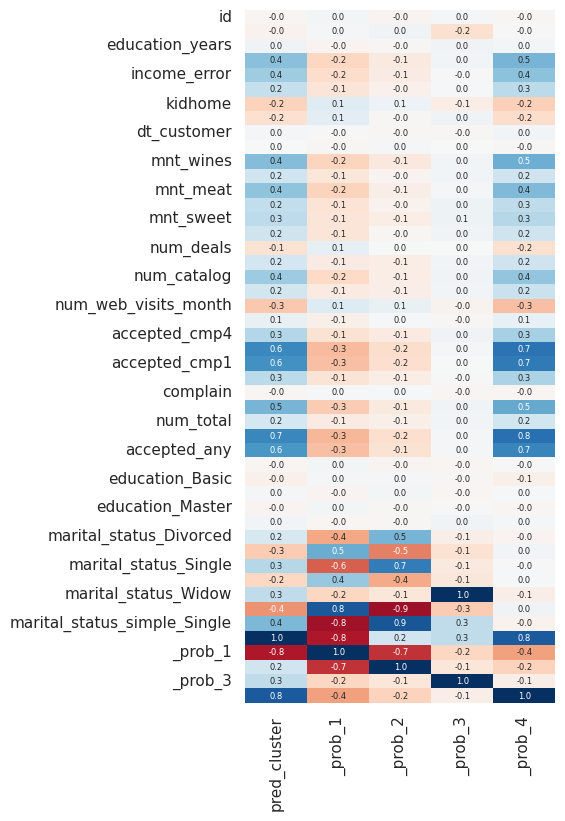

In [239]:
# get correlations 
df_predicted_encoded = pd.get_dummies(df_reordered, drop_first=False)
df_corr = df_predicted_encoded.corr()
df_corr_toplot = df_corr.filter(regex="prob|pred", axis=1)

# heatmap
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(4,9))
sns.heatmap(
    df_corr_toplot,
    cmap='RdBu',
    annot=True,
    fmt=".1f",
    annot_kws={"size": 6},
    vmin=-1, vmax=1,
    cbar=False
)
# save the plot as JPG file
plt.savefig(
    f"output/figures/fig_corrplot_first_look_{n_clusters}_clst_income_pred.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

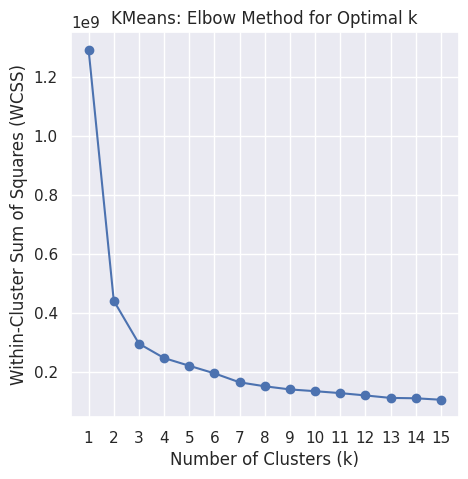

In [240]:
from sklearn.cluster import KMeans

# Calculate WCSS for a range of cluster numbers
wcss = []
k_values = range(1, 15+1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++", max_iter=1000)
    kmeans.fit(df_full_dummies)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(5, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title("KMeans: Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [241]:
def calculate_wcss(gmm, X):
    """Calculate WCSS from a fitted Gaussian Mixture Model.
    
    Parameters:
        gmm: Fitted GaussianMixture model.
        X: Data used to fit the GMM (numpy array).
    
    Returns:
        WCSS: Within-Cluster Sum of Squares.
    """
    labels = gmm.predict(X)
    return sum(
        np.sum(np.linalg.norm(X[labels == i] - mean, axis=1) ** 2)
        for i, mean in enumerate(gmm.means_)
    )

In [242]:
def clustering_statistics(X, labels):
    """Calculate clustering evaluation metrics and return as a DataFrame."""
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    metrics = {
        'silhouette_score': silhouette_score(X, labels),
        'calinski_harabasz_score': calinski_harabasz_score(X, labels),
        'davies_bouldin_score': davies_bouldin_score(X, labels),
    }
    return pd.DataFrame([metrics])

In [243]:
# Predict cluster labels
X = df_full_dummies

# Placeholder for results
results = []

k_values = range(2, 7+1) # clusters (starts k=2 because metrics need at least 2 clusters)
for k in k_values:
    
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    
    # calc clustering statistics
    stats = clustering_statistics(X, labels)
    
    # Add the number of clusters as a new column
    stats['k'] = k
    
    # Append the results
    results.append(stats)

# Concatenate all results into a single DataFrame
final_stats = pd.concat(results, ignore_index=True)

In [244]:
final_stats[["k", "silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"]]

,k,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,2,0.515828,3192.511744,0.753542
1,3,0.364050,1695.795497,1.606216
2,4,0.204269,1146.170670,1.667896
3,5,0.204601,1044.877618,2.481799
4,6,0.086938,562.652639,2.330931
5,7,-0.037698,663.543325,3.324808


- silhouette_score: goes from -1 to +1, higher is better defined clusters
- calinski_harabasz_score: a ratio, higher is better
- davies_bouldin_score: lower is better, minimum value is 0


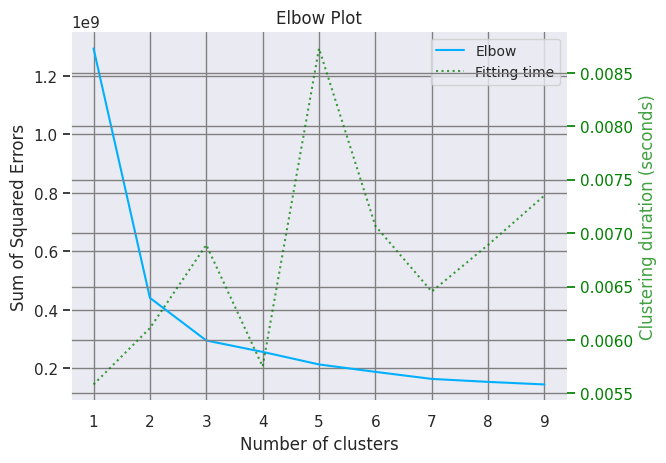

In [245]:
from sklearn_evaluation import plot
model = KMeans(n_init="auto", random_state=424242)
_ = plot.elbow_curve(X, model, range_n_clusters=(1, 2, 3, 4, 5, 6, 7, 8, 9))

<Axes: >

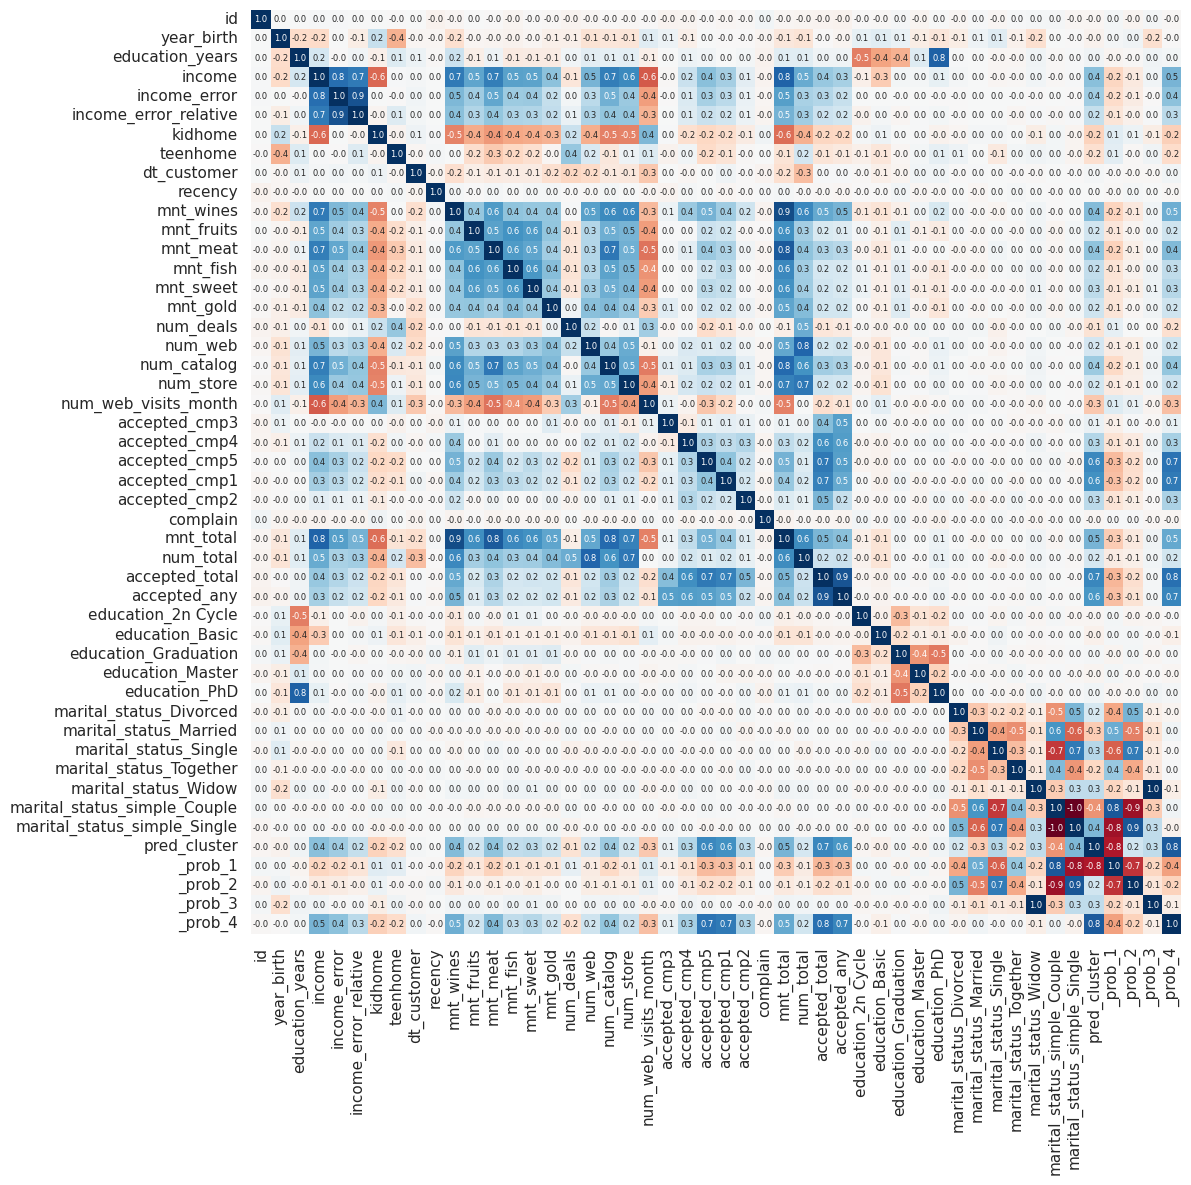

In [246]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(
    df_reordered.corr(),
    cmap='RdBu',
    annot=True,
    fmt=".1f",
    annot_kws={"size": 6},
    vmin=-1, vmax=1,
    cbar=False
)

In [247]:
X.columns

Index(['year_birth', 'education_years', 'income', 'income_error',
       'income_error_relative', 'kidhome', 'teenhome', 'dt_customer',
       'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish',
       'mnt_sweet', 'mnt_gold', 'num_deals', 'num_web', 'num_catalog',
       'num_store', 'num_web_visits_month', 'accepted_cmp3', 'accepted_cmp4',
       'accepted_cmp5', 'accepted_cmp1', 'accepted_cmp2', 'complain',
       'mnt_total', 'num_total', 'accepted_total', 'accepted_any',
       'education_Basic', 'education_Graduation', 'education_Master',
       'education_PhD', 'marital_status_simple_Single'],
      dtype='object')

In [154]:
df_full_dummies.columns

Index(['year_birth', 'education_years', 'income', 'income_error',
       'income_error_relative', 'kidhome', 'teenhome', 'dt_customer',
       'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish',
       'mnt_sweet', 'mnt_gold', 'num_deals', 'num_web', 'num_catalog',
       'num_store', 'num_web_visits_month', 'accepted_cmp3', 'accepted_cmp4',
       'accepted_cmp5', 'accepted_cmp1', 'accepted_cmp2', 'complain',
       'mnt_total', 'num_total', 'accepted_total', 'accepted_any',
       'education_Basic', 'education_Graduation', 'education_Master',
       'education_PhD', 'marital_status_simple_Single'],
      dtype='object')

In [201]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
df = df_reordered.copy()
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(df)
pca.fit_transform(scaled_df)
print(pca.explained_variance_ratio_)

[0.20957866 0.106877   0.07357461 0.05892401 0.04725501]


In [202]:
pca.components_[0]
df.columns

Index(['id', 'year_birth', 'education_years', 'income', 'income_error',
       'income_error_relative', 'kidhome', 'teenhome', 'dt_customer',
       'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish',
       'mnt_sweet', 'mnt_gold', 'num_deals', 'num_web', 'num_catalog',
       'num_store', 'num_web_visits_month', 'accepted_cmp3', 'accepted_cmp4',
       'accepted_cmp5', 'accepted_cmp1', 'accepted_cmp2', 'complain',
       'mnt_total', 'num_total', 'accepted_total', 'accepted_any',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'marital_status_Divorced',
       'marital_status_Married', 'marital_status_Single',
       'marital_status_Together', 'marital_status_Widow',
       'marital_status_simple_Couple', 'marital_status_simple_Single',
       'pred_cluster', '_prob_1', '_prob_2', '_prob_3', '_prob_4'],
      dtype='object')

In [210]:
df_pca = df.copy()
df_pca["pca_1"]  = df.dot(pca.components_[0])
df_pca["pca_2"] = df.dot(pca.components_[1])
df_pca["pca_3"]  = df.dot(pca.components_[2])
df_pca["pca_4"] = df.dot(pca.components_[3])

<Axes: xlabel='pca_1', ylabel='pca_4'>

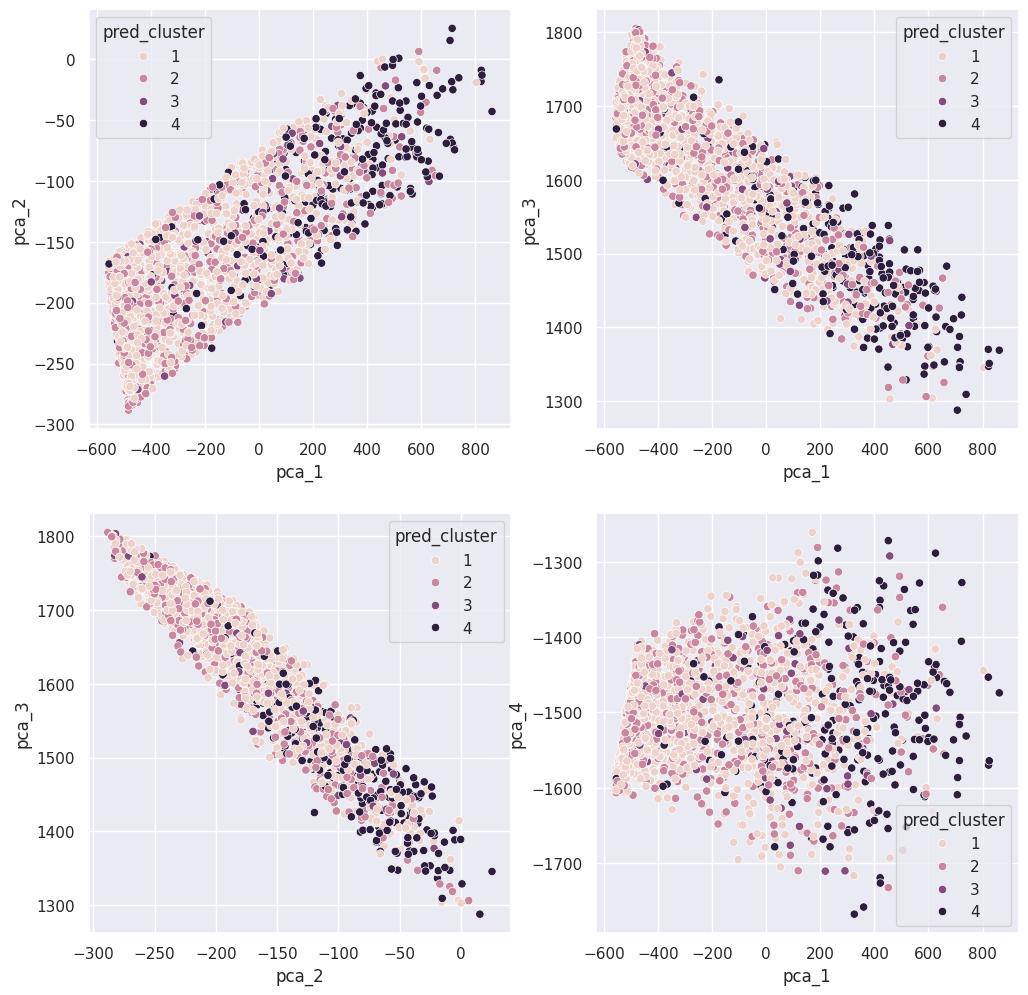

In [218]:
plt.figure(figsize = (12,12))
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df_pca, x="pca_1", y="pca_2", hue="pred_cluster")
ax = plt.subplot(2,2,2)
sns.scatterplot(data=df_pca, x="pca_1", y="pca_3", hue="pred_cluster")
ax = plt.subplot(2,2,3)
sns.scatterplot(data=df_pca, x="pca_2", y="pca_3", hue="pred_cluster")
ax = plt.subplot(2,2,4)
sns.scatterplot(data=df_pca, x="pca_1", y="pca_4", hue="pred_cluster")

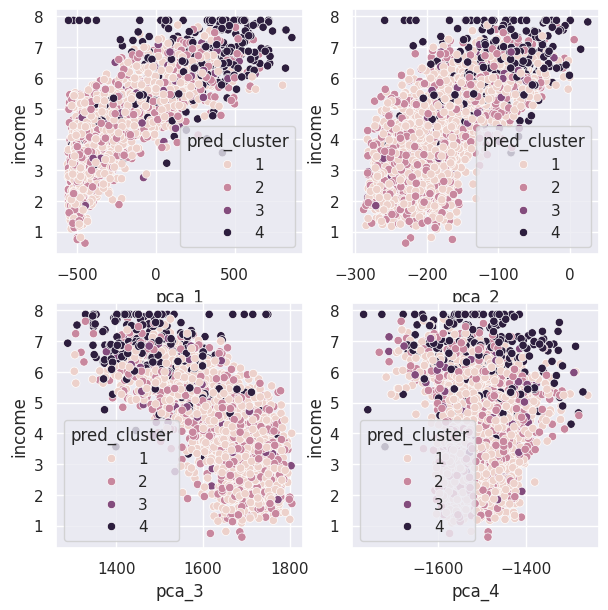

In [219]:
sns.set_theme()
plt.figure(figsize = (7,7))

y_var = "income"
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df_pca, x="pca_1", y=y_var, hue="pred_cluster")
ax = plt.subplot(2,2,2)
sns.scatterplot(data=df_pca, x="pca_2", y=y_var, hue="pred_cluster")
ax = plt.subplot(2,2,3)
sns.scatterplot(data=df_pca, x="pca_3", y=y_var, hue="pred_cluster")
ax = plt.subplot(2,2,4)
sns.scatterplot(data=df_pca, x="pca_4", y=y_var, hue="pred_cluster")
plt.show()

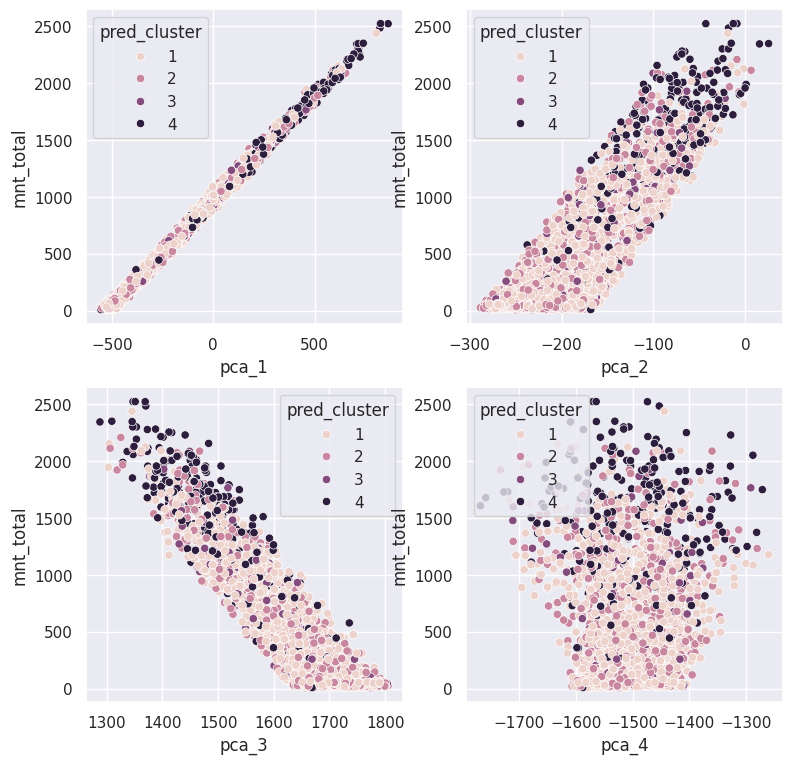

In [221]:
sns.set_theme()
plt.figure(figsize = (9,9))

y_var = "mnt_total"
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df_pca, x="pca_1", y=y_var, hue="pred_cluster")
ax = plt.subplot(2,2,2)
sns.scatterplot(data=df_pca, x="pca_2", y=y_var, hue="pred_cluster")
ax = plt.subplot(2,2,3)
sns.scatterplot(data=df_pca, x="pca_3", y=y_var, hue="pred_cluster")
ax = plt.subplot(2,2,4)
sns.scatterplot(data=df_pca, x="pca_4", y=y_var, hue="pred_cluster")
plt.show()

In [680]:
def summary_stats_by_group(df, group_var, target_var, sorted=False):
    
    # Calculate the summary statistics
    summary = df.groupby(group_var)[target_var].agg(
        count="count",  # Count the number of occurrences
        mean="mean",
        min="min",
        max="max",
        p01=lambda x: x.quantile(0.01),
        p05=lambda x: x.quantile(0.05),
        p10=lambda x: x.quantile(0.10),
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.50),
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95),
        p99=lambda x: x.quantile(0.99)
    ).reset_index()

    # Sort by mean value (descending order)
    if sorted: summary = summary.sort_values(by="mean", ascending=True)

    return summary

In [ ]:
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="income")

In [ ]:
print("num_web")
print(summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="num_web"))
print("num_web_visits_month")
print(summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="num_web_visits_month"))

In [ ]:
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="year_birth")

In [ ]:
df_predicted_encoded.columns

In [ ]:
print("income")
print(summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="income"))
print("mnt_wines")
print(summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="mnt_wines"))
print("mnt_fruits")
print(summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="mnt_fruits"))
print("mnt_total")
print(summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="mnt_total"))



In [ ]:
print("accepted_total")
print(summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="accepted_total"))

In [84]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin_strip_matrix_auto(df, group_var, target_vars, figsize=(9, 7), jitter=True, cut=0):
    """
    Creates a matrix of violin and strip plots for multiple target variables,
    with rows and columns determined automatically.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        group_var (str): The variable used to group the data (y-axis).
        target_vars (list): List of target variables to plot (x-axis).
        figsize (tuple): Overall figure size.
        jitter (bool): Whether to jitter points in the strip plot.
        cut (int): Determines the extent of the violin plot beyond the data.

    Returns:
        None
    """
    num_vars = len(target_vars)
    cols = math.ceil(math.sqrt(num_vars))  # Number of columns
    rows = math.ceil(num_vars / cols)     # Number of rows

    # Create the grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for i, target_var in enumerate(target_vars):
        if i < len(axes):
            ax = axes[i]  # Select subplot
            sns.violinplot(
                x=target_var, y=group_var, data=df, cut=cut, ax=ax, hue=group_var
            )
            if jitter:
                sns.stripplot(
                    x=target_var, y=group_var, data=df,
                    color="black", size=3, alpha=0.5, jitter=0.2, ax=ax
                )
            ax.set_title(f"Distribution of {target_var}")
            ax.set(xlabel=None, ylabel=None)
        else:
            axes[i].axis("off")  # Hide unused subplots

    # Turn off any remaining unused subplots
    for i in range(num_vars, len(axes)):
        axes[i].axis("off")

    plt.show()


In [85]:
df_predicted_encoded['pred_cluster_cat'] = pd.Categorical(df_predicted_encoded["pred_cluster"])

In [ ]:
target_vars = ["income", "income_pred", "mnt_total", "accepted_total"]
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

In [ ]:
target_vars = ['year_birth' ,'accepted_cmp1', 'accepted_cmp2', 'accepted_cmp2', 'accepted_cmp4', 'accepted_cmp5', 'accepted_total', 'accepted_any']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

In [ ]:
target_vars = ['kidhome', 'teenhome', 'dt_customer', 'recency']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

In [ ]:
target_vars = ['mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

In [ ]:
target_vars = ['num_deals', 'num_web', 'num_catalog', 'num_store', 'num_web_visits_month']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)